<a href="https://colab.research.google.com/github/YugantGotmare/Real_Time_Face_Emotion_Detection/blob/master/Real_Time_Face_Emotion_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d deadskull7/fer2013

fer2013.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/fer2013.zip')
zip_ref.extractall('/content/Data')
zip_ref.close()

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPool2D, AveragePooling2D, Input, BatchNormalization, MaxPooling2D, Activation, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing import image
import scipy
import os
import cv2

In [2]:
df = pd.read_csv('/content/Data/fer2013.csv')
df.head(10)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [4]:
value_count = df['emotion'].value_counts()
value_count

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [5]:
df.columns

Index(['emotion', 'pixels', 'Usage'], dtype='object')

In [6]:
df.shape

(35887, 3)

In [7]:
text_label = {0:'anger',
              1:'disgust',
              2:'fear',
              3:'happiness',
              4: 'sadness',
              5: 'surprise',
              6: 'neutral'}

In [8]:
text_label

{0: 'anger',
 1: 'disgust',
 2: 'fear',
 3: 'happiness',
 4: 'sadness',
 5: 'surprise',
 6: 'neutral'}

In [9]:
for label_id, count in value_count.items():
    label = text_label[label_id]
    print(f"{label_id} {label} {count}")

3 happiness 8989
6 neutral 6198
4 sadness 6077
2 fear 5121
0 anger 4953
5 surprise 4002
1 disgust 547


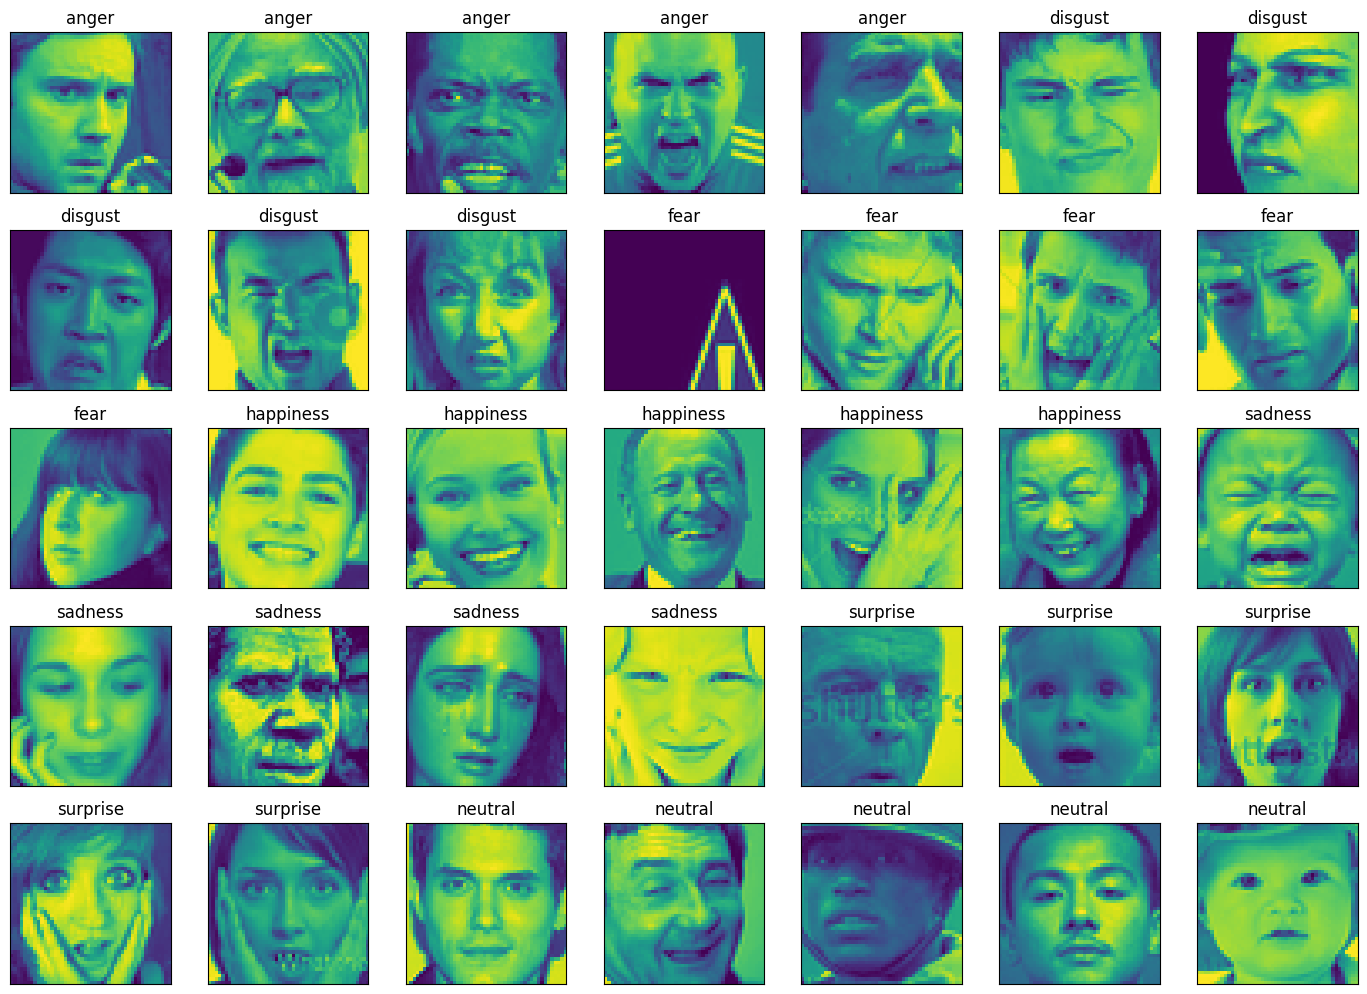

In [10]:
fig = plt.figure(1, (14, 14))
k = 0
for label in sorted(df.emotion.unique()):
  for j in range(5):
    px = df[df.emotion==label].pixels.iloc[k]
    px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
    k += 1
    ax = plt.subplot(7, 7, k)
    ax.imshow(px)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(text_label[label])
    plt.tight_layout()

In [12]:
df['label'] = df['emotion'].map(text_label)
df.head()

,emotion,pixels,Usage,label
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,anger
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,anger
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,fear
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training,sadness
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,neutral


In [13]:
label_order_labels = df['label'].value_counts().sort_values().index
label_order_emotion = df['emotion'].value_counts().sort_values().index

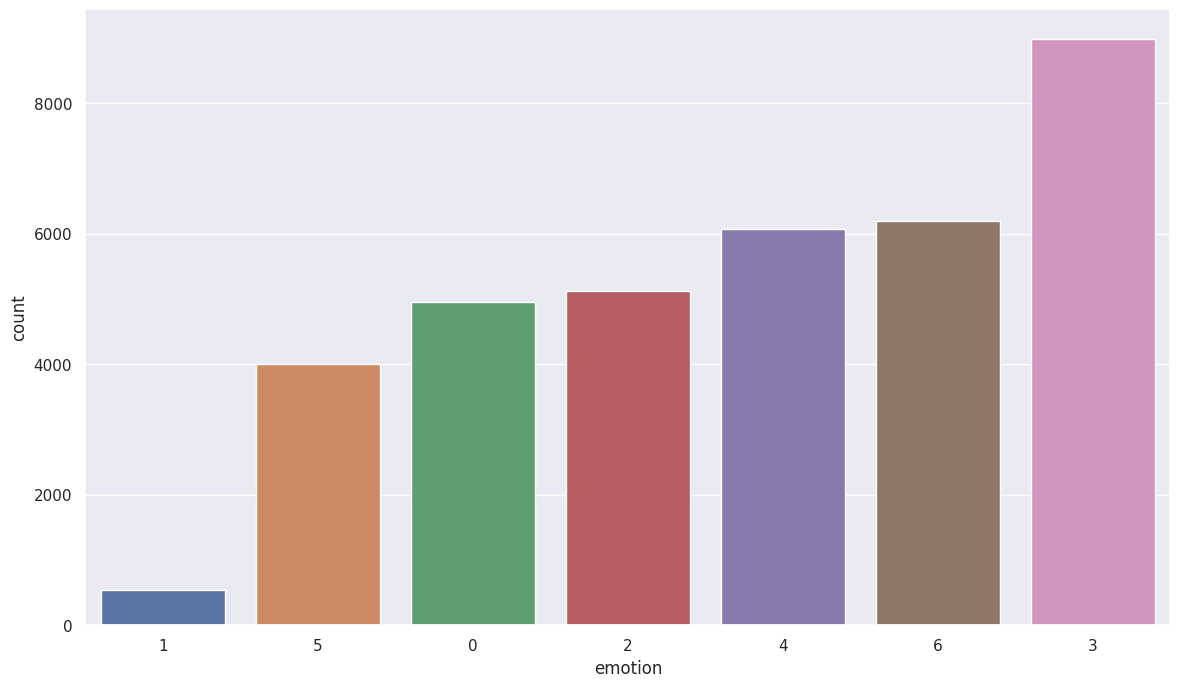

In [14]:
# Plotting the above distribution
plt.figure(figsize=(14, 8))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="emotion", data=df, order=label_order_emotion )

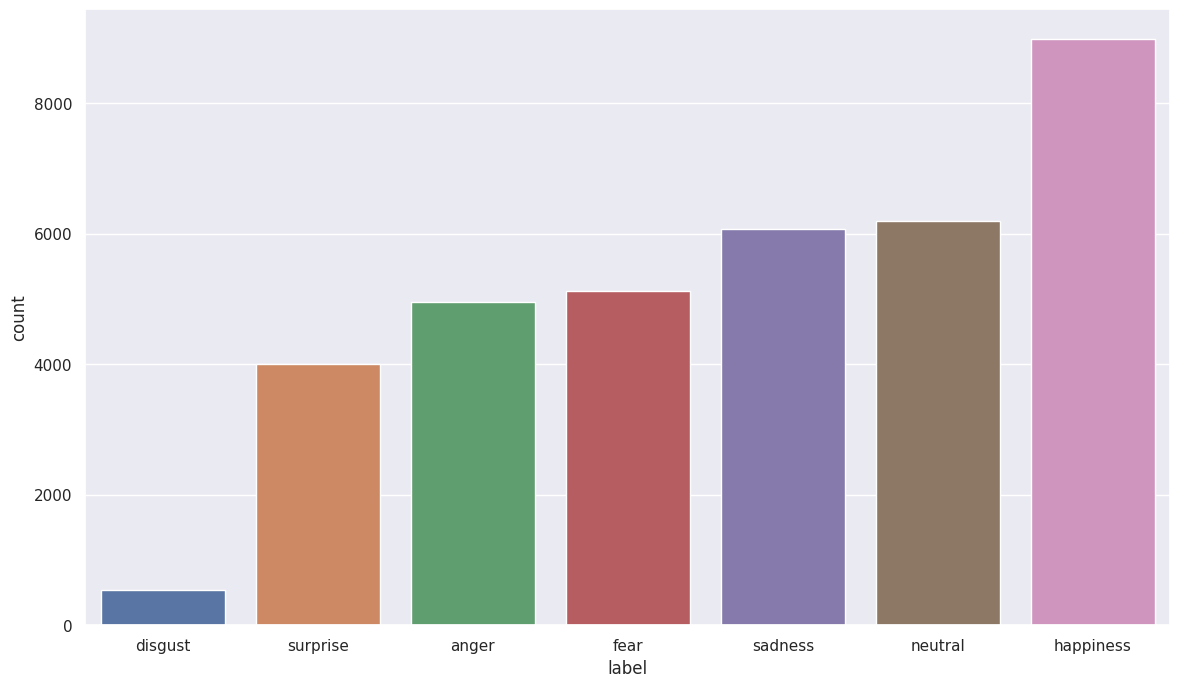

In [15]:
plt.figure(figsize=(14, 8))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="label", data=df, order=label_order_labels)
plt.show()

In [16]:
x_data = df['pixels']
y_data = df['emotion']

In [17]:
# Perform Random Over Sampling to balance the data
oversampler = RandomOverSampler(sampling_strategy='auto')

x_data, y_data = oversampler.fit_resample(x_data.values.reshape(-1,1), y_data)
print(x_data.shape," ",y_data.shape)

(62923, 1)   (62923,)


In [18]:
y_data.value_counts()

0    8989
2    8989
4    8989
6    8989
3    8989
5    8989
1    8989
Name: emotion, dtype: int64

In [19]:
x_data = pd.Series(x_data.flatten())
x_data

0        70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        151 150 147 155 148 133 111 140 170 174 182 15...
2        231 212 156 164 174 138 161 173 182 200 106 38...
3        24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
                               ...                        
62918    65 43 49 55 30 26 43 51 93 96 111 140 152 166 ...
62919    69 70 73 75 77 75 73 72 73 68 66 68 69 78 90 1...
62920    34 30 57 76 81 85 85 77 86 97 119 129 114 78 4...
62921    210 228 195 164 159 176 224 245 232 242 239 24...
62922    31 34 34 29 31 50 67 70 73 76 76 76 77 78 78 7...
Length: 62923, dtype: object

In [20]:
# Normalize the data
x_data = np.array(list(map(str.split, x_data)), np.float32)
x_data/=255
x_data[:10]

array([[0.27450982, 0.3137255 , 0.32156864, ..., 0.41568628, 0.42745098,
        0.32156864],
       [0.5921569 , 0.5882353 , 0.5764706 , ..., 0.75686276, 0.7176471 ,
        0.72156864],
       [0.90588236, 0.83137256, 0.6117647 , ..., 0.34509805, 0.43137255,
        0.59607846],
       ...,
       [0.3019608 , 0.30588236, 0.30980393, ..., 0.49019608, 0.2627451 ,
        0.26666668],
       [0.33333334, 0.32941177, 0.3529412 , ..., 0.22745098, 0.28627452,
        0.32941177],
       [1.        , 0.99607843, 1.        , ..., 0.99607843, 1.        ,
        1.        ]], dtype=float32)

In [21]:
# Reshaping
x_data = x_data.reshape(-1, 48, 48, 1)
x_data.shape

(62923, 48, 48, 1)

In [22]:
y_data = np.array(y_data)
y_data = y_data.reshape(y_data.shape[0], 1)
y_data.shape

(62923, 1)

In [23]:
# Split the data and create train-test set
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2, random_state = 45)

In [24]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((50338, 48, 48, 1), (12585, 48, 48, 1), (50338, 1), (12585, 1))

In [25]:
# Perform One-Hot Encoding on training data
y_train = np_utils.to_categorical(y_train, 7)
y_train.shape

(50338, 7)

In [26]:
# Perform One-Hot Encoding on test data
y_test = np_utils.to_categorical(y_test, 7)
y_test.shape

(12585, 7)

In [33]:
model = Sequential([

    # 1st Conv Layer
    Input((48, 48, 1)),
    Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Dropout(0.25),

    # 2nd Conv Layer
    Conv2D(64, (3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2, 2)),

    # 3rd Conv Layer
    Conv2D(128, (3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Dropout(0.25),

    # 4th Conv Layer
    Conv2D(128, (3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2, 2)),

    # 5th Conv Layer
    Conv2D(256, (3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2, 2)),

    # Flattening the Layer
    Flatten(),

    # Hidden Layers
    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(128, activation='relu'),
    Dropout(0.5),

    # Output Layer
    Dense(7, activation='softmax')
])


In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 dropout (Dropout)           (None, 48, 48, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                        

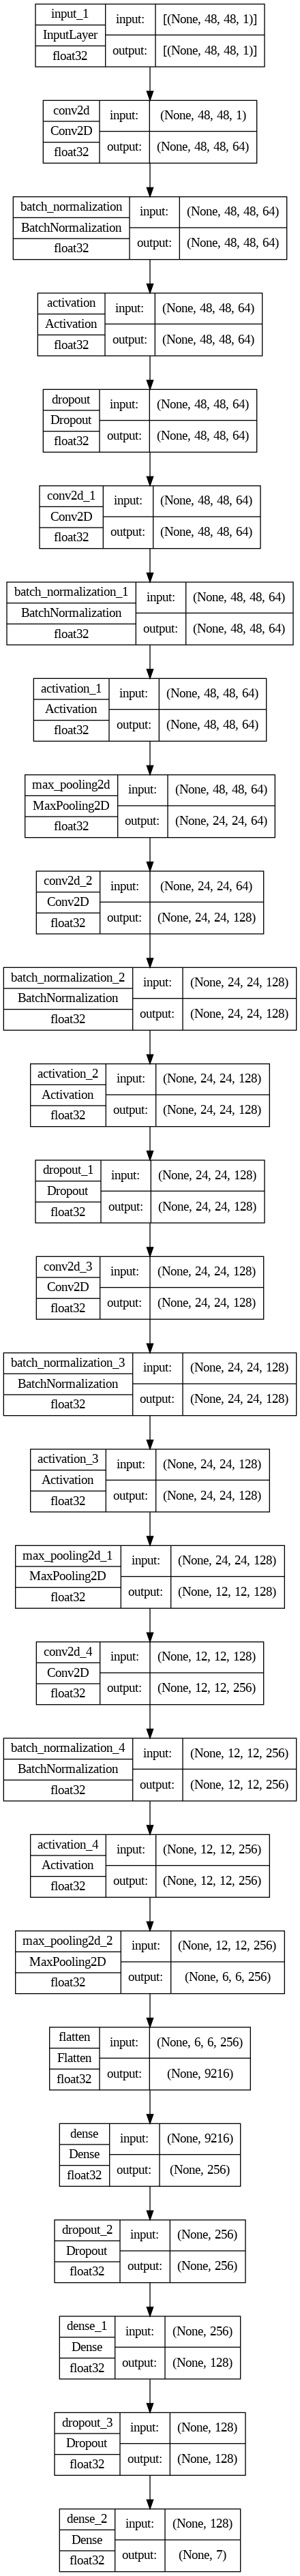

In [30]:
# Model Flowchart
tf.keras.utils.plot_model(model, to_file = "/content/Data/best_model_2.png",
                          show_shapes = True, show_dtype = True)

In [31]:
# Compile the Model
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the Model
history = model.fit(x_train,
                    y_train,
                    epochs = 35,
                    validation_data=(x_test, y_test))

In [30]:
print("Accuracy of our model on test data : " , model.evaluate(x_test, y_test)[1]*100 ,"%")
print("Loss of our model on test data : " , model.evaluate(x_test, y_test)[0])

394/394 [==============================] - 2s 6ms/step - loss: 0.6296 - accuracy: 0.8044
Accuracy of our model on test data :  80.4449737071991 %
394/394 [==============================] - 2s 6ms/step - loss: 0.6296 - accuracy: 0.8044
Loss of our model on test data :  0.6296413540840149


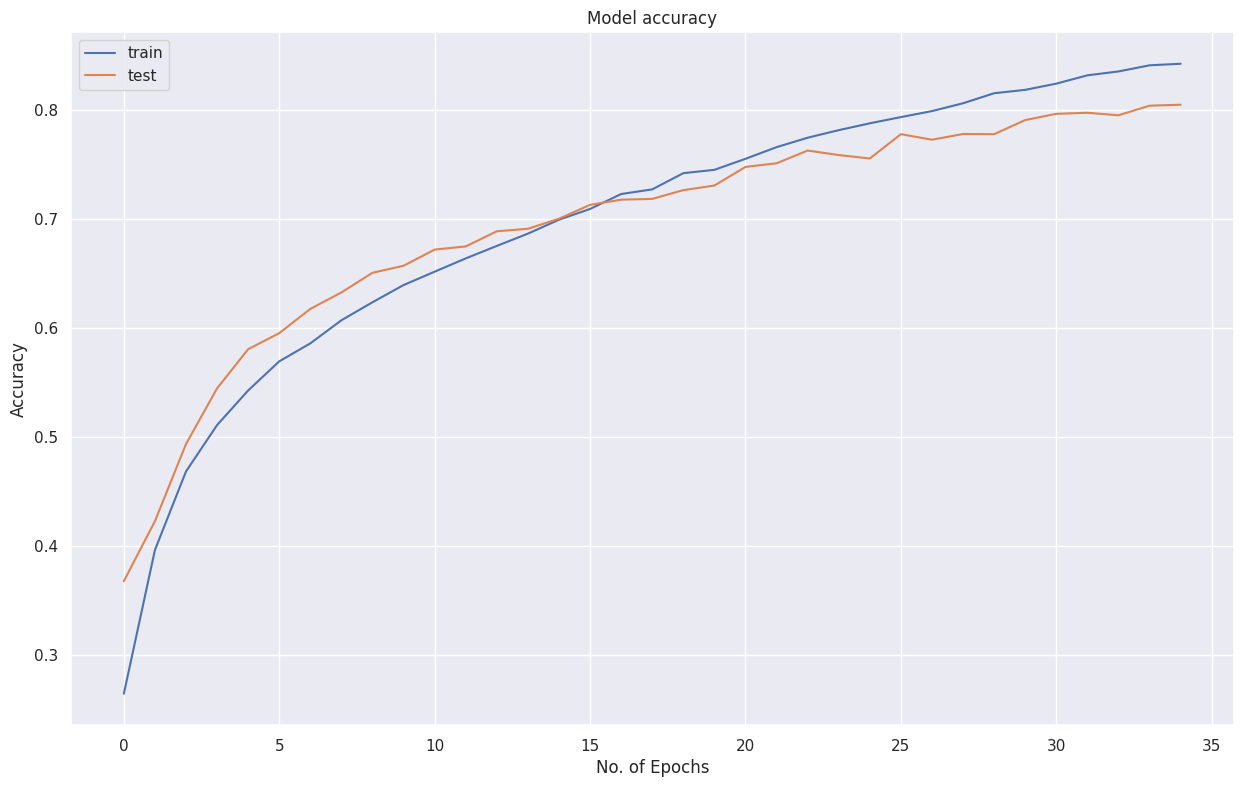

In [31]:
plt.figure(figsize=(15, 9))
# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No. of Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

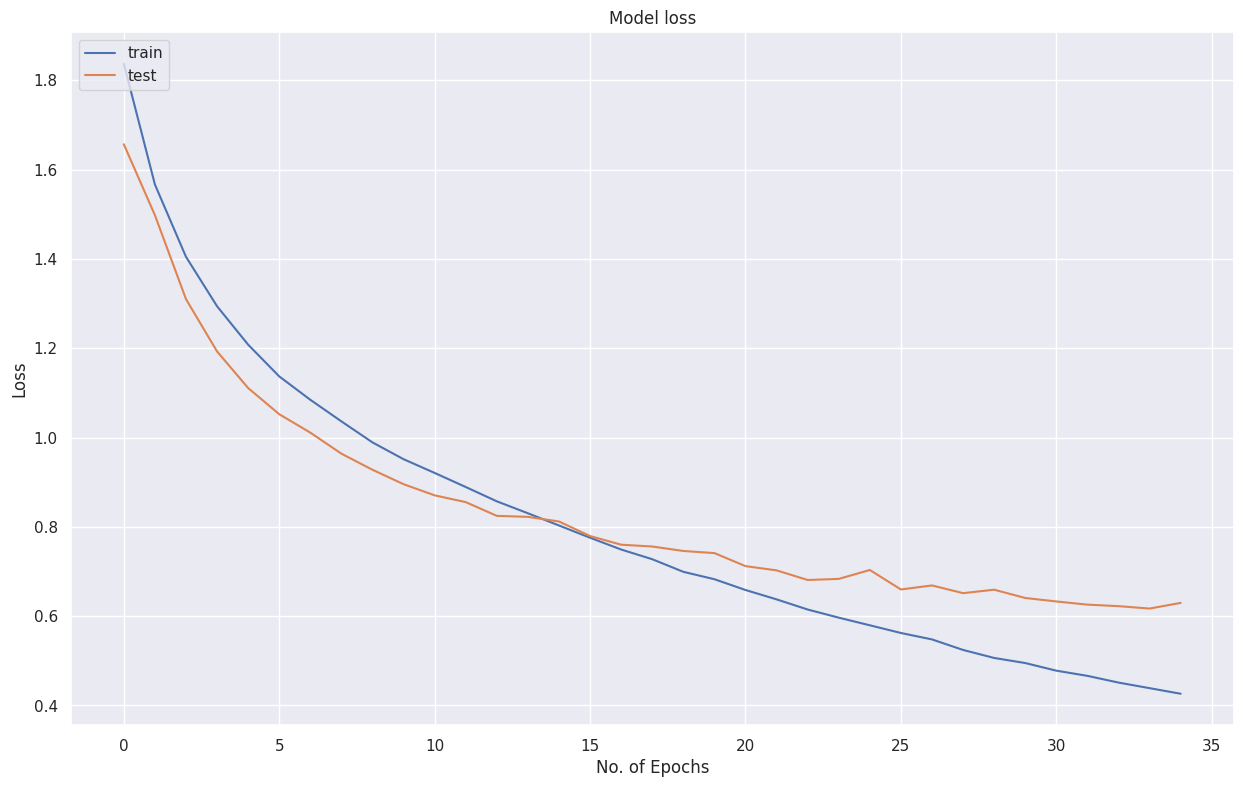

In [32]:
plt.figure(figsize=(15, 9))
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('No. of Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [34]:
# Making Prediction on Test Data
y_pred = model.predict(x_test)
y_result = []
for pred in y_pred:
  y_result.append(np.argmax(pred))
y_result[:10]

394/394 [==============================] - 3s 7ms/step


[6, 5, 5, 6, 1, 0, 3, 4, 1, 2]

In [35]:
y_actual = []
for pred in y_test:
  y_actual.append(np.argmax(pred))
y_actual[:10]

[6, 5, 5, 6, 1, 0, 3, 4, 1, 3]

In [36]:
# Getting Classification Report
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_actual, y_result))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79      1770
           1       0.98      1.00      0.99      1778
           2       0.73      0.73      0.73      1775
           3       0.88      0.78      0.82      1872
           4       0.67      0.67      0.67      1825
           5       0.89      0.93      0.91      1755
           6       0.69      0.75      0.72      1810

    accuracy                           0.80     12585
   macro avg       0.81      0.81      0.81     12585
weighted avg       0.81      0.80      0.80     12585



Text(178.75, 0.5, 'Truth')

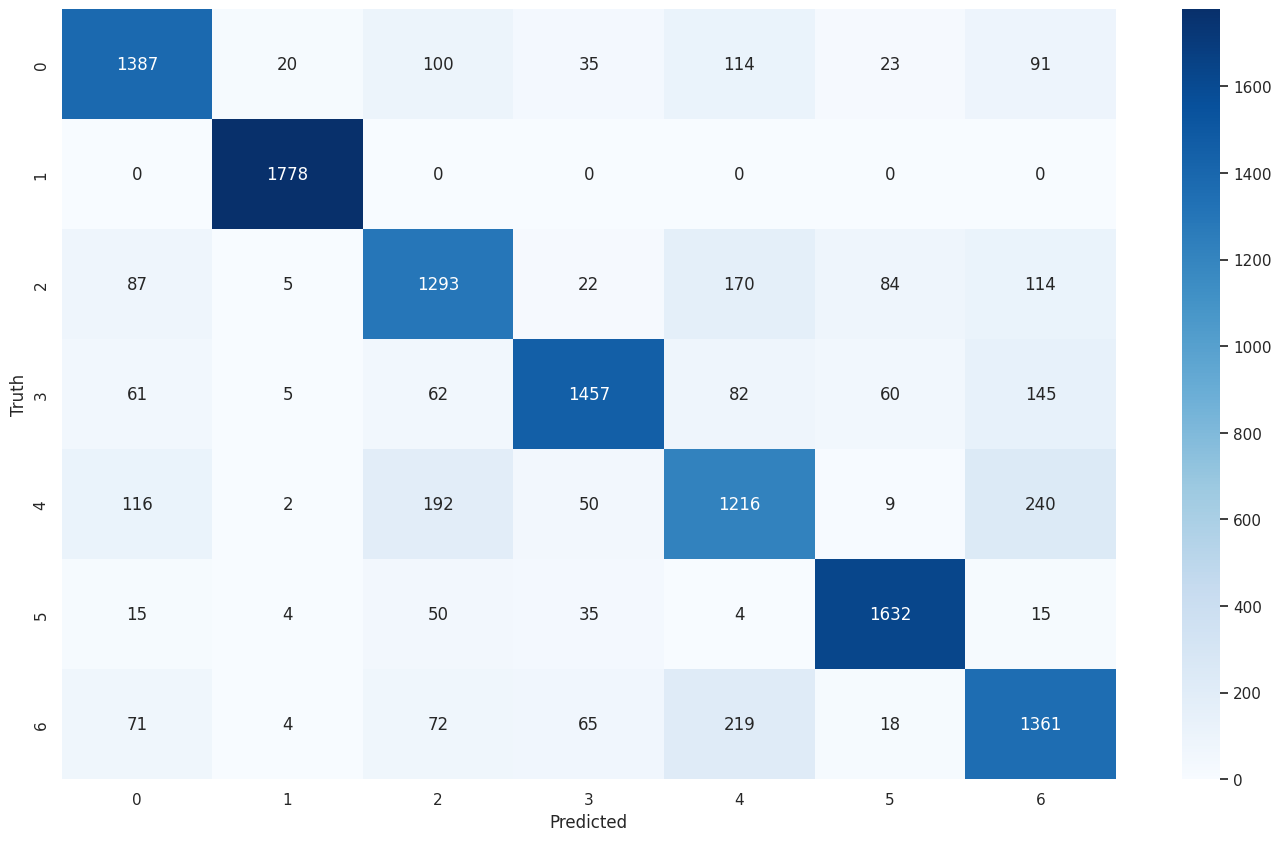

In [43]:
cm = tf.math.confusion_matrix(labels = y_actual, predictions = y_result)

plt.figure(figsize = (17, 10))
sns.heatmap(cm, annot = True, fmt = 'd', cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [38]:
model.save("model2.hdf5")

In [39]:
fer_json = model.to_json()
with open("model2.json", "w") as json_file:
  json_file.write(fer_json)
model.save_weights("fer2.h5")